In [1]:
import math
from random import shuffle
from copy import deepcopy
import torch
import torch.nn.functional as tfunc
import matplotlib.pyplot as plt


torch.set_default_device("cuda")

# Building Dataset

In [2]:
words = open("../names.txt", "r").read().splitlines()
chars = sorted(list(set("".join(words))))
char_to_indx = {char: indx+1 for indx, char in enumerate(chars)}
char_to_indx["."] = 0
indx_to_char = {indx: char for char, indx in char_to_indx.items()}

def train_dev_test_split(words, train_percentage, dev_percentage):
    shuffled_words = deepcopy(words)
    shuffle(shuffled_words)
    train_dev_split_point = math.ceil(len(words) * train_percentage)
    dev_val_split_point = math.floor(
        train_dev_split_point + (len(words) * dev_percentage)
    )
    return (
        shuffled_words[:train_dev_split_point],
        shuffled_words[train_dev_split_point:dev_val_split_point],
        shuffled_words[dev_val_split_point:],
    )

def create_dataset(words, char_to_indx, block_size = 3):
    inputs, labels = [], []
    for word in words:
        # print(word)
        context = [0] * block_size
        for label in word + ".":
            label_indx = char_to_indx[label]
            inputs.append(context)
            labels.append(label_indx)
            # print("".join(indx_to_char[indx] for indx in context), "------>", label)
            context = context[1:] + [label_indx]
        # print()

    return torch.tensor(inputs), torch.tensor(labels)

BLOCK_SIZE = 5
train_words, dev_words, test_words = train_dev_test_split(words, 0.8, 0.1)
train_inputs, train_labels = create_dataset(train_words, char_to_indx, block_size=BLOCK_SIZE)
dev_inputs, dev_labels = create_dataset(dev_words, char_to_indx, block_size=BLOCK_SIZE)
test_inputs, test_labels = create_dataset(test_words, char_to_indx, block_size=BLOCK_SIZE)

# Initializing Model Params

In [42]:
# Params
gen = torch.Generator(device="cuda").manual_seed(2147483647)
EMBED_NUM = 30
HIDDEN_NUM = 300
DOWN_SCALE_PARAMS = (0.07, 0.01, 0.01, 0)

# Uniform configurable params
C = torch.randn((27, EMBED_NUM), requires_grad=True) # Lookup table
weights1 = (torch.randn((BLOCK_SIZE * EMBED_NUM, HIDDEN_NUM), requires_grad=True) * DOWN_SCALE_PARAMS[0]).detach().requires_grad_()
weights2 = (torch.randn((HIDDEN_NUM, 27), requires_grad=True) * DOWN_SCALE_PARAMS[2]).detach().requires_grad_()
bias2 = (torch.randn(27, requires_grad=True) * DOWN_SCALE_PARAMS[3]).detach().requires_grad_()

batch_norm_gain = torch.ones((1, HIDDEN_NUM), requires_grad=True)
batch_norm_bias = torch.zeros((1, HIDDEN_NUM), requires_grad=True)
batch_norm_running_mean = torch.zeros((1, HIDDEN_NUM))
batch_norm_running_std = torch.ones((1, HIDDEN_NUM))

parameters = [C, weights1, weights2, bias2, batch_norm_gain, batch_norm_bias]
# parameters = [C, weights1, bias1, weights2, bias2]
print(f"TOTAL PARAMS: {sum([param.nelement() for param in parameters])}")

TOTAL PARAMS: 54537


# Training Model

In [43]:
EPOCHS = 200000
MINI_BATCH_SIZE = 100
LOG_EVERY = 10000

losses = []
learning_rate = 0.1
for indx in range(0, EPOCHS):
    mini_batch_indxs = torch.randint(0, train_inputs.shape[0], (MINI_BATCH_SIZE,))
    mini_batch_inputs = train_inputs[mini_batch_indxs]
    mini_batch_labels = train_labels[mini_batch_indxs]

    embed = C[mini_batch_inputs]
    joined_embed = embed.view(embed.shape[0], embed.shape[1] * embed.shape[2])
    preact = joined_embed @ weights1
    current_mean, current_std = preact.mean(0, keepdim=True), preact.std(0, keepdim=True)
    batch_norm_preact = batch_norm_gain * ((preact - current_mean) / current_std) + batch_norm_bias
    layer1_out = torch.tanh(batch_norm_preact)
    logits = layer1_out @ weights2 + bias2
    loss = tfunc.cross_entropy(logits, mini_batch_labels)

    with torch.no_grad():
        batch_norm_running_mean = 0.99 * batch_norm_running_mean + 0.01 * current_mean
        batch_norm_running_std = 0.99 * batch_norm_running_std + 0.01 * current_std

    for param in parameters:
        param.grad = None

    if indx < 2 * EPOCHS // 3: learning_rate = 0.01 
    loss.backward(retain_graph=True)
    for param in parameters:
        param.data += -learning_rate * param.grad
    
    if indx % LOG_EVERY == 0: print(f"{indx}/{EPOCHS} : {loss.item()}")
    losses.append(loss.log10().item()
)

0/200000 : 3.3168725967407227
10000/200000 : 2.0796194076538086
20000/200000 : 2.0188536643981934
30000/200000 : 2.1862926483154297
40000/200000 : 2.0629336833953857
50000/200000 : 2.0053725242614746
60000/200000 : 1.9205108880996704
70000/200000 : 1.9781280755996704
80000/200000 : 2.007481575012207
90000/200000 : 2.0366594791412354
100000/200000 : 1.9866344928741455
110000/200000 : 2.026547431945801
120000/200000 : 2.099771499633789
130000/200000 : 2.080590009689331
140000/200000 : 1.872315526008606
150000/200000 : 1.941248893737793
160000/200000 : 1.997975468635559
170000/200000 : 1.841263771057129
180000/200000 : 1.7813730239868164
190000/200000 : 1.86961030960083


# Training loss curve plot

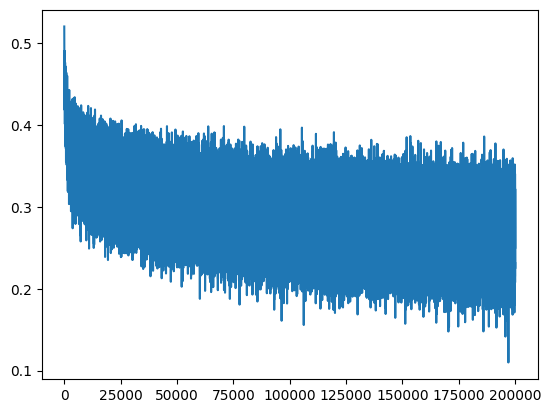

In [44]:
plt.plot(list(range(EPOCHS)), losses)

# Eval Model with Dev Data

In [45]:
@torch.no_grad()
def calc_loss(inputs, labels):
    embed = C[inputs]
    joined_embed = embed.view(embed.shape[0], embed.shape[1] * embed.shape[2])
    preact = joined_embed @ weights1 + bias1
    batch_norm_preact = batch_norm_gain * ((preact - batch_norm_running_mean) / batch_norm_running_std) + batch_norm_bias
    layer1_out = torch.tanh(batch_norm_preact)
    logits = layer1_out @ weights2 + bias2
    loss = tfunc.cross_entropy(logits, labels)
    return loss

print(f"Train loss: {calc_loss(train_inputs, train_labels).item()}")
print(f"Dev loss: {calc_loss(dev_inputs, dev_labels).item()}")

Train loss: 1.8377010822296143
Dev loss: 2.019843339920044


In [ ]:
# Best train loss: 1.8737189769744873
# Best dev loss: 2.012103319168091

# Sample from the model

In [10]:
NUM_SAMPLES = 20
g = torch.Generator(device="cuda").manual_seed(2147483647 + 10)
for _ in range(NUM_SAMPLES): 
    out = []
    context = [0] * BLOCK_SIZE
    while True:
        embed = C[torch.tensor([context])]
        joined_embed = embed.view(embed.shape[0], embed.shape[1] * embed.shape[2])
        layer1_out = torch.tanh(joined_embed @ weights1 + bias1)
        logits = layer1_out @ weights2 + bias2
        probs = tfunc.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
  
    print(''.join(indx_to_char[i] for i in out)) # decode and print the generated word

brentse.
ezrieh.
francar.
harsrahlee.
lidzyon.
rahhend.
chrac.
adoni.
jensin.
melo.
arellonk.
alstende.
tengzond.
kaylah.
aannj.
ruany.
doria.
aviri.
thiyen.
moraya.
